# Zonal structure of NEMO and TAO spectra

In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numpy import pi
import scipy.io as sio
import matplotlib.colors as Colors
%matplotlib inline 
import warnings
import pandas as pd
from tqdm import tqdm
from utils.transform_utils import *
from utils.data_processing_utils import *
from utils.theoretical_utils import *

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 14, 'font.size': 14})
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['text.usetex'] = False

%load_ext autoreload
%autoreload 2

In [30]:
smooth_N = 21
SNR = 35
nmodes=6
cutoff = 20

In [4]:
# Load in full TAO data 
t_TAO_full, lat_TAO, lon_TAO, D_TAO_full, ds_TAO_full = load_TAO(nyears_start=0, nyears_end=37.6, NEMO_year=False, ilats = 'default', ilons = 'default')
lon_TAO_midpoints = np.array([158.5,172.5,185,197.5,212.5,227.5,242.5,257.5,272.5])

# Load in full NEMO data, subsample in x because there's so much
t, lat_NEMO, lon_NEMO, D_NEMO_full, ds_NEMO_full = load_NEMO(daily_mean=True,lons=np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[-1],100),lats='default')

# Load in year of TAO data 
t_TAO_year, lat_TAO, lon_TAO, D_TAO_year, ds_TAO_year = load_TAO(NEMO_year=True, ilats = 'default', ilons = 'default')

# Load in sampled NEMO data
t, lat_TAO, lon_TAO, D_NEMO_sampled, ds_NEMO_sampled = load_NEMO(daily_mean=True,lons=lon_TAO,lats=lat_TAO,lon_lims=[lon_TAO[0],lon_TAO[-1]])

# Add in gaps:
D_NEMO_sampled = np.where(np.isnan(D_TAO_year),np.nan,D_NEMO_sampled)



In [5]:
# Load in meridional modes. We'll use the first baroclinic mode (cm = 2.8)
V_modes_TAO , P_modes_TAO = calc_meridional_modes(lat_TAO,N=nmodes,cm=2.8)
V_modes_NEMO , P_modes_NEMO = calc_meridional_modes(lat_NEMO,N=nmodes,cm=2.8)


In [6]:
# Get the theoretical frequencies
freqbc1, freqbc2, lon_speeds = find_baroclinic_speeds(nmodes,lon_lims=[lon_TAO_midpoints[0],lon_TAO_midpoints[-1]],lat_lims=[-12,12],average = False)


In [31]:
# Do high pass filters (two stage approach - first remove a running mean to remove endpoint issues)

D_NEMO_full_hf1 = D_NEMO_full - smooth(D_NEMO_full,smooth_N)
D_NEMO_sampled_hf1 = D_NEMO_sampled - smooth(D_NEMO_sampled,smooth_N)
D_TAO_year_hf1 = D_TAO_year - smooth(D_TAO_year,smooth_N)

D_NEMO_full_lf = least_squares_spectrum_t_multi(D_NEMO_full_hf1, t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]
D_NEMO_full_hf = D_NEMO_full_hf1 - D_NEMO_full_lf
D_NEMO_full_hf -= np.nanmean(D_NEMO_full_hf,axis=0)

D_NEMO_sampled_lf = least_squares_spectrum_t_multi(D_NEMO_sampled_hf1, t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]
D_NEMO_sampled_hf = D_NEMO_sampled_hf1 - D_NEMO_sampled_lf
D_NEMO_sampled_hf -= np.nanmean(D_NEMO_sampled_hf,axis=0)

D_TAO_year_lf = least_squares_spectrum_t_multi(D_TAO_year_hf1, t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]
D_TAO_year_hf = D_TAO_year_hf1 - D_TAO_year_lf
D_TAO_year_hf -= np.nanmean(D_TAO_year_hf,axis=0)



In [32]:
# For the full TAO data, we need a windowed approach. Let's first create the windowed data, in yearly (370 day) intervals
window_width=370
Nsamples = D_TAO_full.shape[0]
window_starts = np.arange(0,Nsamples-window_width,window_width)
window_mid = window_starts+window_width/2
Nwindows = window_starts.shape[0]
D_TAO_windowed = np.zeros((window_width,D_TAO_full.shape[1],D_TAO_full.shape[2],Nwindows))
D_TAO_full_lf = np.zeros_like(D_TAO_windowed)
D_TAO_full_hf1 = np.zeros_like(D_TAO_windowed)
for iw in range(Nwindows):
    D_TAO_windowed[:,:,:,iw] = D_TAO_full[window_starts[iw]:window_starts[iw]+window_width]
    D_TAO_full_hf1[:,:,:,iw] = D_TAO_windowed[:,:,:,iw] - smooth(D_TAO_windowed[:,:,:,iw],smooth_N)
    D_TAO_full_lf[:,:,:,iw] = least_squares_spectrum_t_multi(D_TAO_full_hf1[:,:,:,iw], t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]

D_TAO_full_hf = D_TAO_full_hf1 - D_TAO_full_lf
D_TAO_full_hf -= np.nanmean(D_TAO_full_hf,axis=0)

In [33]:
# Now do least squares fits:

omvec, power_NEMO_full, fit_NEMO_full = least_squares_spectrum_t_y(
    D_NEMO_full_hf, t, lat_NEMO, min_period=2, max_period=370,y_modes=P_modes_NEMO,  SNR=SNR, max_period_cutoff = cutoff)

omvec, power_NEMO_sampled, fit_NEMO_sampled = least_squares_spectrum_t_y(
    D_NEMO_sampled_hf, t, lat_TAO, min_period=2, max_period=370,y_modes=P_modes_TAO,  SNR=SNR, max_period_cutoff = cutoff)

omvec, power_TAO_year, fit_TAO_year = least_squares_spectrum_t_y(
    D_TAO_year_hf, t, lat_TAO, min_period=2, max_period=370,y_modes=P_modes_TAO,  SNR=SNR, max_period_cutoff = cutoff)

100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.38s/it]


In [34]:
# Function can't take 4 dimensions, need a for loop for windows
len_omvec = 167
power_TAO_full = np.zeros((len_omvec,nmodes,D_TAO_full_hf.shape[2],Nwindows))
fit_TAO_full = np.zeros_like(D_TAO_full_hf)
for iw in range(Nwindows):
    omvec, power_TAO_full[:,:,:,iw], fit_TAO_full[:,:,:,iw] = least_squares_spectrum_t_y(
        D_TAO_full_hf[:,:,:,iw], t, lat_TAO, min_period=2, max_period=370,y_modes=P_modes_TAO,  SNR=SNR, max_period_cutoff = cutoff)

power_TAO_full_av = np.nanmean(power_TAO_full,axis=3)

100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.50s/it]


In [35]:
mydict = {'omvec':omvec,
         'power_NEMO_full':power_NEMO_full,
         'power_NEMO_sampled':power_NEMO_sampled,
         'power_TAO_year':power_TAO_year,
         'power_TAO_full':power_TAO_full,
         'power_TAO_full_av':power_TAO_full_av,
         'D_NEMO_full_hf':D_NEMO_full_hf,
         'D_NEMO_sampled_hf':D_NEMO_sampled_hf,
         'D_TAO_year_hf':D_TAO_year_hf,
         'D_TAO_full_hf':D_TAO_full_hf 
         }
sio.savemat('../data/zonal_structure_all_SNR35.mat',mydict)

In [40]:
contents = sio.loadmat('../data/zonal_structure_res_spectrum_NEMO_SNR25.mat')
omvec_NEMO_full = np.squeeze(contents['omvec'])
power_NEMO_full = np.squeeze(contents['power_NEMO'])
fitted_data_NEMO_full = np.squeeze(contents['fitted_data_NEMO'])


Text(0.5, -0.02, 'Longitude ($^\\circ$E)')

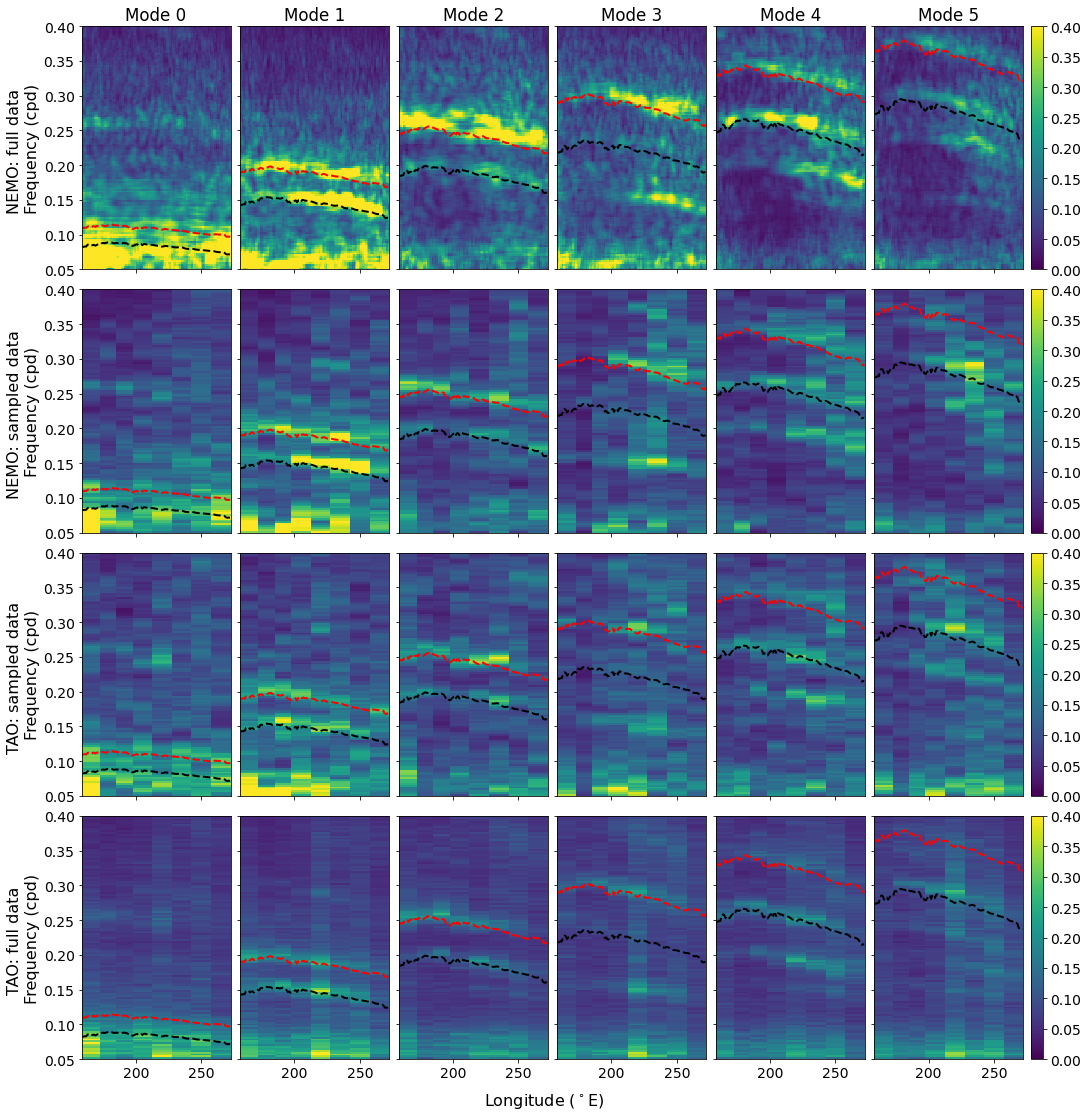

In [29]:
fig, ax = plt.subplots(4,6,figsize = (15,15),constrained_layout=True)
vmax = 0.4
vmin = 0.0
nfilt = 5

# Plot full NEMO
for i in range(ax.shape[1]):
    p = ax[0,i].pcolormesh(lon_NEMO, omvec,smooth(power_NEMO_full[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot spatially sampled NEMO
for i in range(ax.shape[1]):
    p = ax[1,i].pcolormesh(lon_TAO_midpoints, omvec,smooth(power_NEMO_sampled[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot spatially sampled TAO
for i in range(ax.shape[1]):
    p = ax[2,i].pcolormesh(lon_TAO_midpoints, omvec,smooth(power_TAO_year[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot full TAO
nfilt = 1
for i in range(ax.shape[1]):
    p = ax[3,i].pcolormesh(lon_TAO_midpoints, omvec,smooth(power_TAO_full_av[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot frequency curves
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].plot(lon_speeds,freqbc1[j,:],'--',linewidth=2,color='red')
        ax[i,j].plot(lon_speeds,freqbc2[j,:],'--',linewidth=2,color='black')

# Set titles
for i in range(ax.shape[1]):
    ax[0,i].set_title(f'Mode {i}')

# Set ylims
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_ylim([0.05,0.4])
        
# Set xlims
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_xlim([lon_TAO_midpoints[0],lon_TAO_midpoints[-1]])
        

# Remove x ticklabels
for i in range(ax.shape[0]-1):
    for j in range(ax.shape[1]):
        ax[i,j].axes.xaxis.set_ticklabels([])

# Remove y ticklabels
for i in range(ax.shape[0]):
    for j in range(1,ax.shape[1]):
        ax[i,j].axes.yaxis.set_ticklabels([])
        
# Set colorbars
for i in range(ax.shape[0]):
    fig.colorbar(p, ax = ax[i,5])

ax[0,0].set_ylabel('NEMO: full data \nFrequency (cpd)',fontsize=16)
ax[1,0].set_ylabel('NEMO: sampled data \nFrequency (cpd)',fontsize=16)
ax[2,0].set_ylabel('TAO: sampled data \nFrequency (cpd)',fontsize=16)
ax[3,0].set_ylabel('TAO: full data \nFrequency (cpd)',fontsize=16)

fig.text(0.5, -0.02, 'Longitude ($^\circ$E)', ha='center',fontsize=16)

#fig.savefig('./new_figs/fig3_all_zonal_structure.png',transparent=False, bbox_inches="tight" )

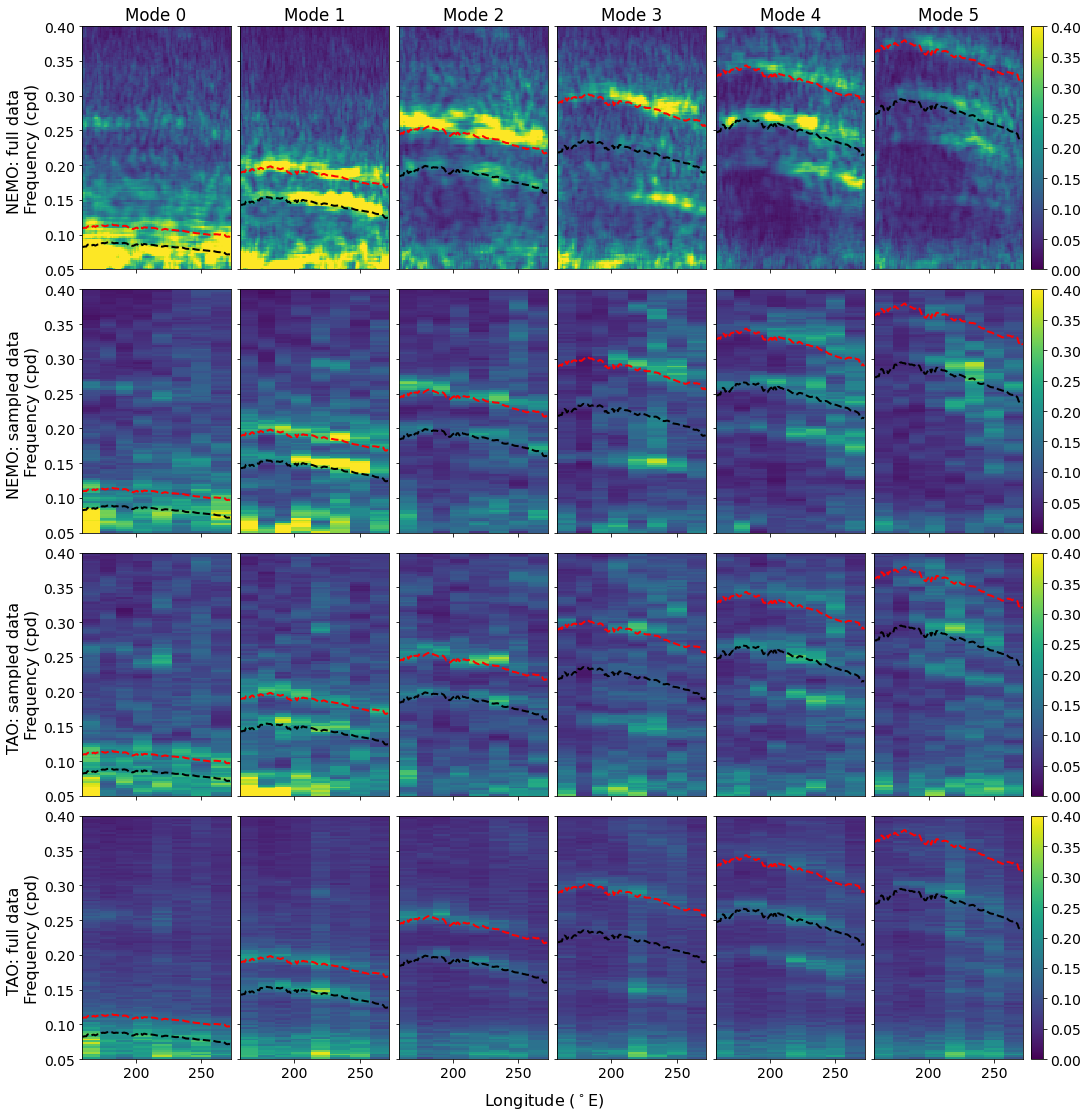

In [37]:
fig, ax = plt.subplots(4,6,figsize = (15,15),constrained_layout=True)
vmax = 0.4
vmin = 0.0
nfilt = 5

# Plot full NEMO
for i in range(ax.shape[1]):
    p = ax[0,i].pcolormesh(lon_NEMO, omvec,smooth(power_NEMO_full[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot spatially sampled NEMO
for i in range(ax.shape[1]):
    p = ax[1,i].pcolormesh(lon_TAO_midpoints, omvec,smooth(power_NEMO_sampled[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot spatially sampled TAO
for i in range(ax.shape[1]):
    p = ax[2,i].pcolormesh(lon_TAO_midpoints, omvec,smooth(power_TAO_year[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot full TAO
nfilt = 1
for i in range(ax.shape[1]):
    p = ax[3,i].pcolormesh(lon_TAO_midpoints, omvec,smooth(power_TAO_full_av[:,i,:],nfilt),vmin=vmin,vmax=vmax)

# Plot frequency curves
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].plot(lon_speeds,freqbc1[j,:],'--',linewidth=2,color='red')
        ax[i,j].plot(lon_speeds,freqbc2[j,:],'--',linewidth=2,color='black')

# Set titles
for i in range(ax.shape[1]):
    ax[0,i].set_title(f'Mode {i}')

# Set ylims
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_ylim([0.05,0.4])
        
# Set xlims
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_xlim([lon_TAO_midpoints[0],lon_TAO_midpoints[-1]])
        

# Remove x ticklabels
for i in range(ax.shape[0]-1):
    for j in range(ax.shape[1]):
        ax[i,j].axes.xaxis.set_ticklabels([])

# Remove y ticklabels
for i in range(ax.shape[0]):
    for j in range(1,ax.shape[1]):
        ax[i,j].axes.yaxis.set_ticklabels([])
        
# Set colorbars
for i in range(ax.shape[0]):
    fig.colorbar(p, ax = ax[i,5])

ax[0,0].set_ylabel('NEMO: full data \nFrequency (cpd)',fontsize=16)
ax[1,0].set_ylabel('NEMO: sampled data \nFrequency (cpd)',fontsize=16)
ax[2,0].set_ylabel('TAO: sampled data \nFrequency (cpd)',fontsize=16)
ax[3,0].set_ylabel('TAO: full data \nFrequency (cpd)',fontsize=16)

fig.text(0.5, -0.02, 'Longitude ($^\circ$E)', ha='center',fontsize=16)

fig.savefig('./new_figs/fig3_all_zonal_structure_second_draft.png',transparent=False, bbox_inches="tight" )

In [24]:
#Let's do a test for overfitting
# Let's run a loop to test different sig values
SNRvec = [1e-4,1e-3,1e-2,1e-1,1,10,100]
mse = np.zeros((len(SNRvec)))
mean_power = np.zeros((len(SNRvec)))
for iss, SNR in tqdm(enumerate(SNRvec)):
    omvec, power, fitted_data = least_squares_spectrum_t_y(D_TAO_hf[:,:,3], t, lat_TAO, min_period=2, max_period=370, y_modes=P_modes,  SNR=SNR)
    mse[iss] = np.nanmean((D_TAO_hf[:,:,3] - fitted_data)**2)
    mean_power[iss] = np.nanmean(power**2)


fig, ax = plt.subplots(2,1)
ax[0].plot(SNRvec,mse)
ax[1].plot(SNRvec,mean_power)
ax[0].set_xscale('log')
ax[1].set_xscale('log')

7it [00:15,  2.17s/it]


(0.0, 2.0)

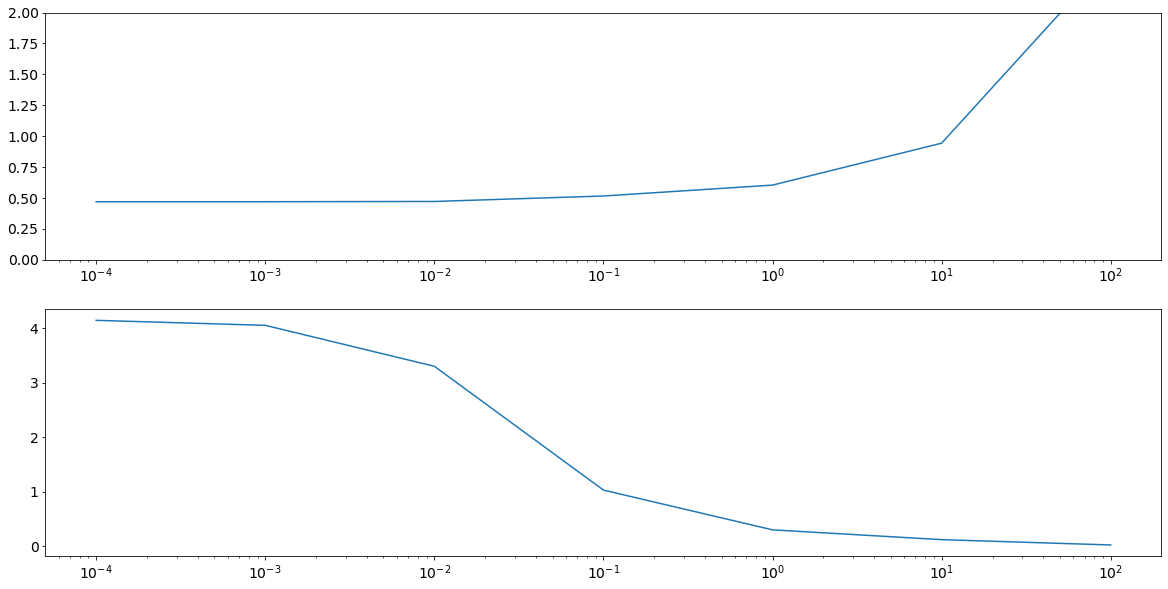

In [36]:
fig, ax = plt.subplots(2,1)
ax[0].plot(SNRvec,mse)
ax[1].plot(SNRvec,mean_power)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylim([0,2])